# Figure 1

### Summary
This script makes Figure 1, showing VHF source time-altitude distribution along with the Cypress storm trajectory.

### Input
This script uses the `exported.dat` file obtained from using the lasso selection tool in the XLMA software.

### Output
This script generates a `.png` image of Figure 1.

In [1]:
# libraries

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from dataclasses import dataclass

plt.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize": 12})

In [2]:
# variables

EXPORTED_FILE = r"data/LYLOUT_251124_cypress.exported.dat"
COUNTY_FILE = r"data/county/county.shp"

TIME_START = pd.Timestamp("2025-11-24 18:00")
TIME_END = pd.Timestamp("2025-11-24 20:00")

ISO_0  = 4.312
ISO_40 = 9.574
LCL = 0.762
LNB = 12.377

STATIONS = {
    "A": (29.9392519, -95.6464853), #CyFair ISD
    "D": (29.6196495, -95.6576330), #Sugar Land Airport
    "F": (29.5050035, -95.4759368), #Southwest Houston Airport
    "H": (29.7913451, -94.8828558), #Katoen-Natie
    "I": (30.6461530, -96.2979347), #Aggieland
    "J": (30.0019908, -95.3840236), #Lone Star College
    "K": (29.4407146, -95.2733530), #Alvin ISD
    "M": (29.3159000, -94.8220000), #Galveston
    "P": (30.0581250, -95.0614192), #LT May Community Center
}

@dataclass(frozen=True)
class LMA_CENTER:
    lat: float = 29.76
    lon: float = -95.37

In [3]:
# preparing data

# lylout exported data file
lylout_data = pd.read_csv(EXPORTED_FILE, skiprows=10, header=None, names=["seconds", "lat", "lon", "alt", "chi", "num_stations", "power", "mask"], sep=r"\s+")
lylout_data = lylout_data[(lylout_data.chi <= 2) & (lylout_data.num_stations >= 6) & (lylout_data.alt >= 0) & (lylout_data.alt <= 20_000)]
lylout_data["datetime"] = pd.Timestamp("2025-11-24") + pd.to_timedelta(lylout_data.seconds, unit="s")
lylout_data = lylout_data.loc[lylout_data["datetime"].between(TIME_START, TIME_END, inclusive="both")]
lylout_data = lylout_data.set_index("datetime")

# county shapefile
county_gdf = gpd.read_file(r"c:/data/maps/county/county.shp")
if county_gdf.crs is None:
    county_gdf = county_gdf.set_crs(epsg=4326)
elif county_gdf.crs.to_epsg() != 4326:
    county_gdf = county_gdf.to_crs(epsg=4326)
county_gdf = county_gdf.cx[-97:-94, 28:31]

# spc storm reports
spc = pd.DataFrame({
    "label": ["EF1 Cypress", "EF2 Klein"],
    "datetime": [pd.Timestamp("2025-11-24 19:26:00"),  pd.Timestamp("2025-11-24 19:46:00")],
    "lat": [29.94, 30.04],
    "lon": [-95.68, -95.54],
})

In [4]:
# processing data

# plot 1
# altitude median line
medians = lylout_data.resample("1min").agg(alt_median=("alt", "median"))
medians.alt_median /= 1000
medians
# 2d histogram
time_bins = pd.date_range(TIME_START, TIME_END, freq='1min', inclusive='both').to_numpy()
alt_bins = np.arange(0, 21, 1)
H, _, _ = np.histogram2d(lylout_data.index, lylout_data.alt / 1000, bins=[time_bins, alt_bins])

# plot 2
# tracks per minute
tracks = lylout_data.resample("1min").agg(lon=("lon", "median"), lat=("lat", "median"))
tracks["num_sources"] = lylout_data.resample("1min").size()

In [5]:
# plotting helpers
def lat_formatter(y, pos):
    deg = abs(y)
    hemi = 'N' if y >= 0 else 'S'
    return f"{deg:.1f}°{hemi}"

def lon_formatter(x, pos):
    deg = abs(x)
    hemi = 'E' if x >= 0 else 'W'
    return f"{deg:.1f}°{hemi}"

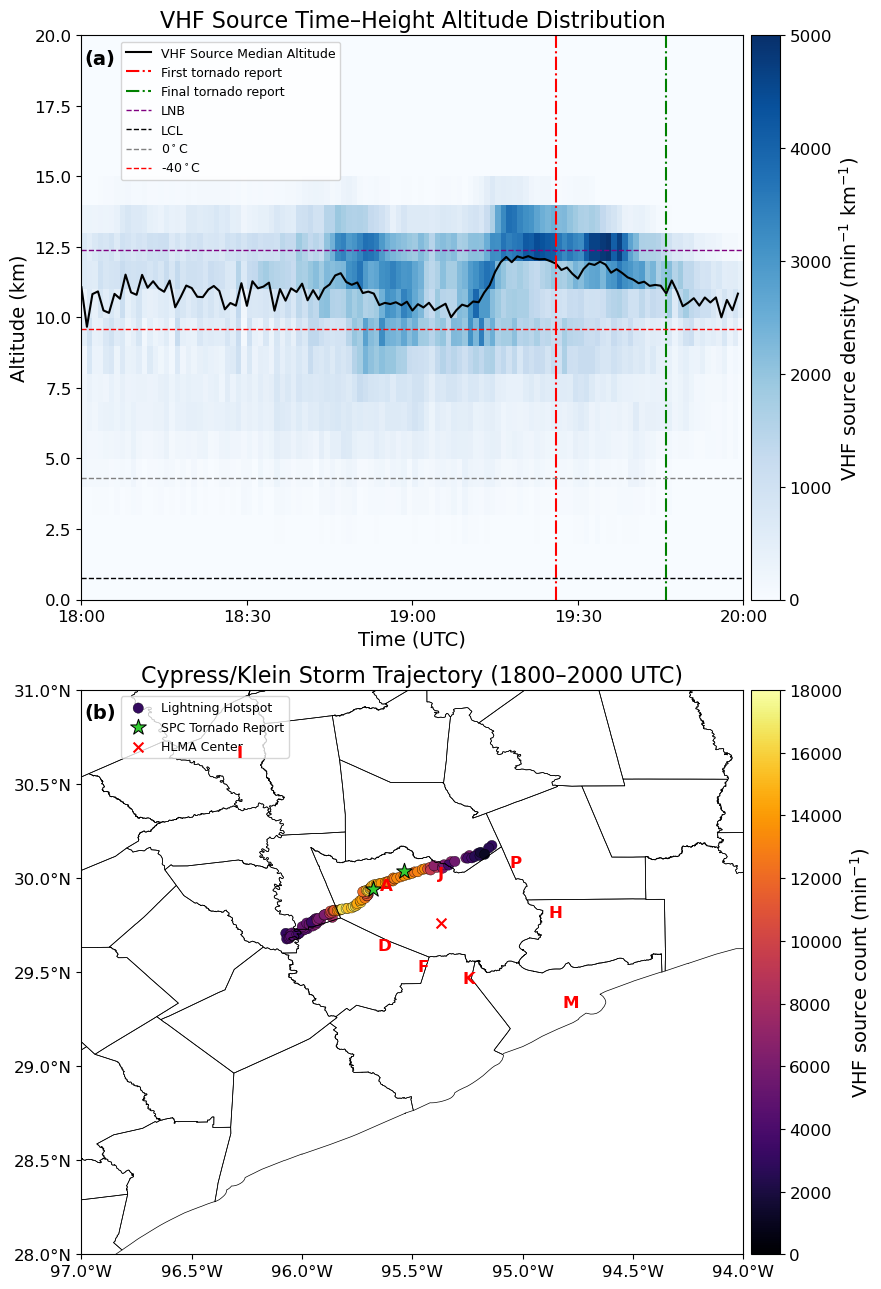

In [7]:
fig = plt.figure(figsize=(9, 13))
gs = fig.add_gridspec(2, 1, height_ratios=[1.0, 1.0])

# fig a
ax1 = fig.add_subplot(gs[0])

# source - alt histogram
h = ax1.imshow(H.T, origin='lower', aspect='auto', cmap='Blues', vmin=0, vmax=5000, extent=[TIME_START, TIME_END, 0, 20])
cbar1 = plt.colorbar(h, ax=ax1, pad=0.01)
cbar1.set_label("VHF source density (min$^{-1}$ km$^{-1}$)", fontsize=14)

# black median line plot
ax1.plot(medians.index, medians.alt_median, color="black", lw=1.5, label="VHF Source Median Altitude")

# spc report vertical lines
ax1.axvline(spc.iloc[0].datetime, color="red", linestyle="-.", label='First tornado report')
ax1.axvline(spc.iloc[1].datetime, color="green", linestyle="-.", label='Final tornado report')

# alt horizontal lines
ax1.axhline(LNB, color="purple", linestyle="--", lw=1, label=r"LNB")
ax1.axhline(LCL, color="black", linestyle="--", lw=1, label=r"LCL")
ax1.axhline(ISO_0, color="gray", linestyle="--", lw=1, label=r"0$^\circ$C")
ax1.axhline(ISO_40, color="red", linestyle="--", lw=1, label=r"-40$^\circ$C")

# axes formatting
ax1.set_xlim(TIME_START, TIME_END)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.set_ylim(0, 20)
ax1.set_ylabel("Altitude (km)", fontsize=14)
ax1.set_xlabel("Time (UTC)", fontsize=14)
ax1.set_title("VHF Source Time–Height Altitude Distribution", fontsize=16)
ax1.text(0.005, 0.95, "(a)", transform=ax1.transAxes, fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", bbox_to_anchor=(0.05, 1), fontsize=9)

# fig b
ax2 = fig.add_subplot(gs[1])

# counties
county_gdf.geometry.boundary.plot(ax=ax2, linewidth=0.5, color='black')

# storm track points
sc = ax2.scatter(tracks.lon, tracks.lat, c=tracks.num_sources, cmap="inferno", s=55, edgecolor="black", linewidth=0.25, label="Lightning Hotspot", vmin=0, vmax=18_000)

# spc storm reports
ax2.scatter(spc.lon, spc.lat, s=140, marker='*', color='limegreen', edgecolor="black", linewidth=0.75, label='SPC Tornado Report')

# lma stations
for letter, (lat, lon) in STATIONS.items():
    ax2.text(lon, lat,letter, fontsize=12, fontweight="bold", color="red", zorder=8)
# lma center
ax2.scatter(LMA_CENTER.lon, LMA_CENTER.lat, marker='x', s=50, color='red', label='HLMA Center')

# axes formatting
ax2.set_aspect('auto')
ax2.set_xlim(-97, -94)
ax2.set_ylim(28, 31)
ax2.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
ax2.set_title("Cypress/Klein Storm Trajectory (1800–2000 UTC)", fontsize=16)
cbar2 = plt.colorbar(sc, ax=ax2, pad=0.01)
cbar2.set_label("VHF source count (min$^{-1}$)", fontsize=14)
ax2.text(0.005, 0.95, "(b)", transform=ax2.transAxes, fontsize=14, fontweight="bold")
ax2.legend(loc="upper left", bbox_to_anchor=(0.05, 1), fontsize=9)

plt.savefig("figure1.png", bbox_inches="tight")
plt.tight_layout()